## Importy

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import EarlyStopping

from utils.dataset_tools import DatasetTools

2025-09-06 19:43:20.548537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757180600.576615   25498 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757180600.585072   25498 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757180600.605440   25498 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757180600.605464   25498 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757180600.605467   25498 computation_placer.cc:177] computation placer alr

In [2]:
DATASET_PATH = '../dataset/full_dataset.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,sample_id,frame,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,landmark_21_x,landmark_21_y,landmark_21_z
0,1,0,A,0.345417,0.648431,-1.125724e-07,0.363545,0.620765,-0.010274,0.367171,...,-0.003865,0.321722,0.551512,-0.008457,0.326903,0.565844,-0.005724,0.329682,0.577548,-0.001789
1,1,1,A,0.366266,0.597102,-9.622672e-08,0.391580,0.578109,-0.012907,0.406190,...,0.000685,0.356418,0.497935,-0.004451,0.361665,0.515749,-0.001988,0.363353,0.523833,0.002337
2,1,2,A,0.400966,0.572690,-1.089629e-07,0.424555,0.552354,-0.004017,0.439723,...,-0.004296,0.383425,0.481909,-0.009304,0.389207,0.502081,-0.005430,0.391897,0.513775,-0.000924
3,1,3,A,0.418257,0.573744,-1.190043e-07,0.441344,0.563031,-0.007786,0.460869,...,-0.002903,0.402536,0.489501,-0.009669,0.406139,0.510639,-0.006567,0.409394,0.523706,-0.001918
4,1,4,A,0.431913,0.582072,-1.241054e-07,0.453692,0.577044,-0.009167,0.474907,...,-0.004793,0.417201,0.501486,-0.012369,0.419653,0.524298,-0.008715,0.422120,0.535854,-0.003439


In [3]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# podział na sekwencje
sequences, labels = DatasetTools.divide_into_sequences(df)

# normalizacja punktów względem nadgarstka
sequences = np.array([DatasetTools.normalize_wrist(seq) for seq in sequences])

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(labels)  # 'A'...'Z' itd. -> 0...35

# One-hot encoding (36 klas)
y_cat = tf.keras.utils.to_categorical(y, num_classes=len(encoder.classes_))

# Konwersja typów
X = sequences.astype(np.float32)
print(X.shape, y_cat.shape)


(22372, 30, 63) (22372, 36)


In [4]:
from sklearn.model_selection import train_test_split

# najpierw train+val vs test (np. 70% : 30%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_cat, test_size=0.3, random_state=42, stratify=y
)

# następnie train vs val (np. 80% : 20% z trainval)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=np.argmax(y_trainval, axis=1)
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)


Train: (12528, 30, 63) (12528, 36)
Val: (3132, 30, 63) (3132, 36)
Test: (6712, 30, 63) (6712, 36)


## Architektura modelu

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(30, 63)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, activation='tanh', recurrent_activation='sigmoid')
    ),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(36, activation='softmax')
])


model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)


model.summary()


I0000 00:00:1757180612.858420   25498 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1733 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       196,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,116 (1.46 MB)

 Trainable params: 382,116 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping]
)


Epoch 1/50


I0000 00:00:1757180621.633504   25554 cuda_dnn.cc:529] Loaded cuDNN version 90300


392/392 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.3204 - loss: 2.2223 - val_accuracy: 0.8151 - val_loss: 0.5214
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.7891 - loss: 0.5534 - val_accuracy: 0.8988 - val_loss: 0.2895
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8751 - loss: 0.3512 - val_accuracy: 0.8969 - val_loss: 0.2689
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8888 - loss: 0.3128 - val_accuracy: 0.9333 - val_loss: 0.1623
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9158 - loss: 0.2370 - val_accuracy: 0.9215 - val_loss: 0.2293
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9252 - loss: 0.2065 - val_accuracy: 0.9307 - val_loss: 0.1893
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9321 - loss: 0.1894 - val_accuracy: 0.9553 - val_loss: 0.1161
Epoch 8/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9486 - loss: 0.1458 - val_accurac

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 0.0555
Test accuracy: 0.9878


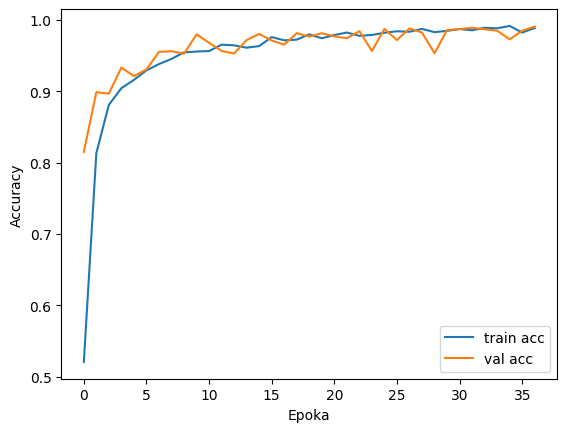

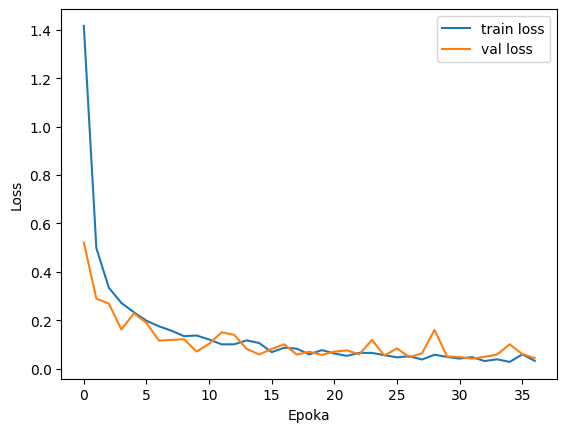

In [8]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9870 - loss: 0.0598
Test loss: 0.0555
Test accuracy: 0.9878


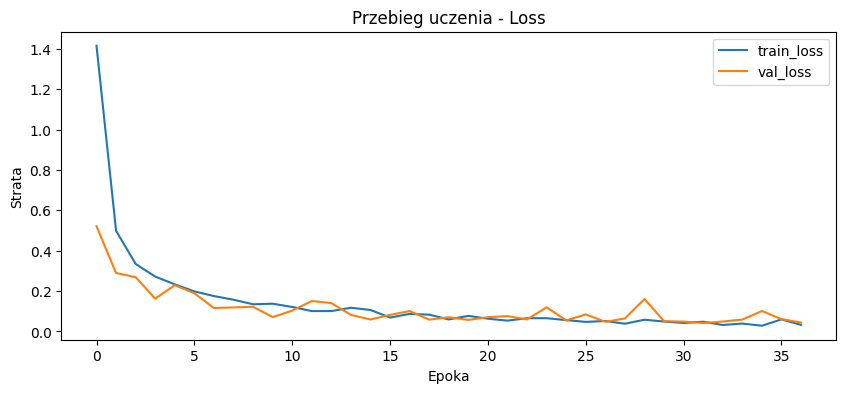

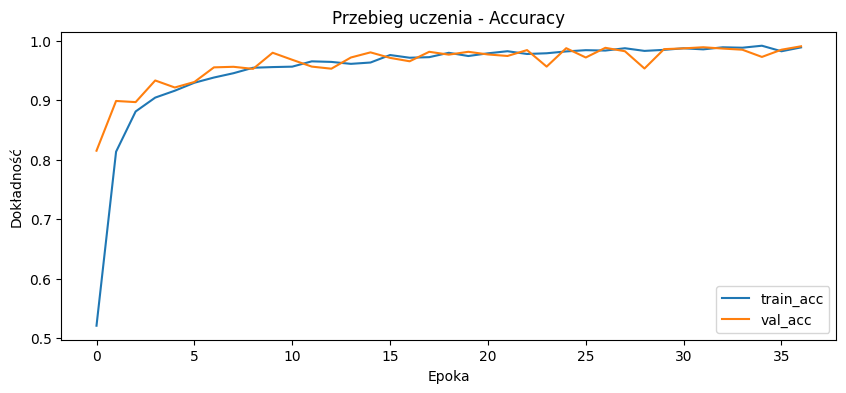

In [10]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Przebieg uczenia - Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.title('Przebieg uczenia - Accuracy')
plt.legend()
plt.show()


In [14]:
# Zapis w formacie SavedModel
model.save("bilstm.keras")

In [11]:
!python -m tf2onnx.convert --saved-model saved_model_dir --output model.onnx

/usr/bin/python: Error while finding module specification for 'tf2onnx.convert' (ModuleNotFoundError: No module named 'tf2onnx')


In [12]:
import onnx
import onnxruntime as ort

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

ort_sess = ort.InferenceSession("model.onnx")
outputs = ort_sess.run(None, {"input_0": X_val.astype(np.float32)})


FileNotFoundError: [Errno 2] No such file or directory: 'model.onnx'